# 基于Keras  使用预训练模型进行猫十二分类
在先前的测试中，使用简单卷积网络训练20个epoch基本达到收敛，在测试集上正确率为47%。使用ResNet和VGG时，效果反而不如简单卷积网络，考虑到训练集只有一千多张图片，参数庞大的神经网络可能会造成过拟合，即使加入dropout和Data augmentation，仍然达不到预期效果。于是尝试使用了Keras中的部分预训练模型，最终选择ResNet50。

### 导入需要的包

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np

### 读取数据

In [9]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = './cats'

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2160 files belonging to 12 classes.
Using 1728 files for training.
Found 2160 files belonging to 12 classes.
Using 432 files for validation.


### 归一化

将数据归一化到(0，1)之间，能有效提升CNN的表现

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9450862


### 数据增强

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

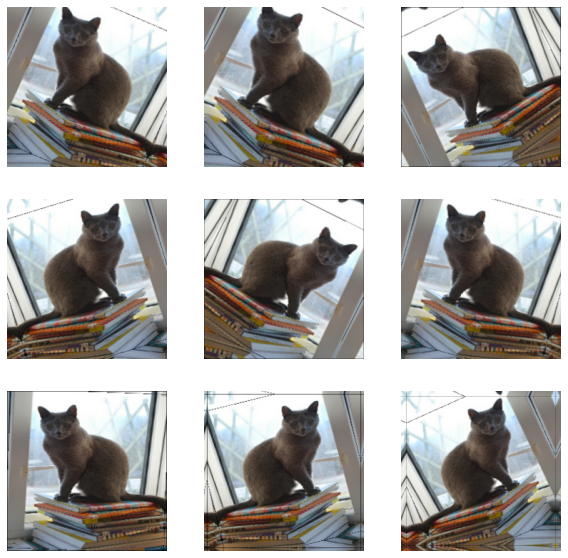

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### 使用ResNet50 预训练模型

In [14]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [15]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [16]:
base_model.trainable = False

In [17]:
base_model.summary()  # 查看网络结构


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### 在底部添加分类层

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [19]:
prediction_layer = keras.layers.Dense(12)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 12)


### 查看整体模型结构

In [20]:
model = tf.keras.Sequential([
  data_augmentation,
  base_model,
  global_average_layer,
  prediction_layer
])

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588     
Total params: 23,612,300
Trainable params: 24,588
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
epochs =10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 76s 1s/step - loss: 2.5219 - accuracy: 0.1655 - val_loss: 2.1828 - val_accuracy: 0.2801
Epoch 2/10
54/54 [==============================] - 77s 1s/step - loss: 2.0340 - accuracy: 0.3171 - val_loss: 1.8062 - val_accuracy: 0.4398
Epoch 3/10
54/54 [==============================] - 77s 1s/step - loss: 1.7097 - accuracy: 0.4444 - val_loss: 1.5380 - val_accuracy: 0.5116
Epoch 4/10
54/54 [==============================] - 77s 1s/step - loss: 1.4672 - accuracy: 0.5399 - val_loss: 1.3279 - val_accuracy: 0.5810
Epoch 5/10
54/54 [==============================] - 77s 1s/step - loss: 1.2725 - accuracy: 0.6209 - val_loss: 1.1879 - val_accuracy: 0.6273
Epoch 6/10
54/54 [==============================] - 77s 1s/step - loss: 1.1506 - accuracy: 0.6528 - val_loss: 1.0732 - val_accuracy: 0.6667
Epoch 7/10
54/54 [==============================] - 79s 1s/step - loss: 1.0408 - accuracy: 0.6863 - val_loss: 0.9877 - val_accuracy: 0.6782
Epoch 8/10
54/54 [==

### 可视化展示训练结果

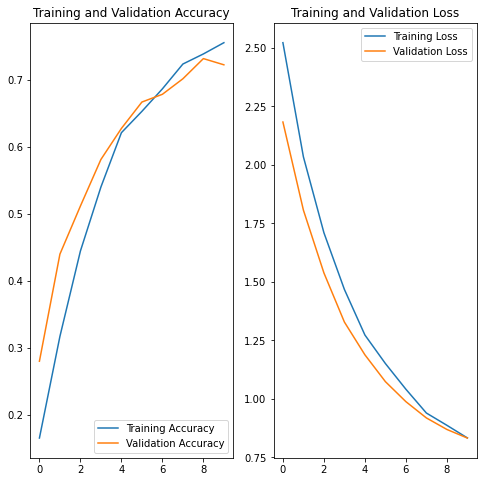

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 预训练10个epoch之后在测试集上的准确率达到了72%

进一步考虑对预训练模型进行微调，整体模型有175个层，对顶层10个图层进行训练

In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 165
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs =10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 88s 2s/step - loss: 0.6417 - accuracy: 0.7922 - val_loss: 0.5379 - val_accuracy: 0.8125
Epoch 2/10
54/54 [==============================] - 89s 2s/step - loss: 0.3735 - accuracy: 0.8819 - val_loss: 0.4907 - val_accuracy: 0.8241
Epoch 3/10
54/54 [==============================] - 88s 2s/step - loss: 0.2505 - accuracy: 0.9265 - val_loss: 0.4465 - val_accuracy: 0.8403
Epoch 4/10
54/54 [==============================] - 89s 2s/step - loss: 0.1753 - accuracy: 0.9491 - val_loss: 0.4539 - val_accuracy: 0.8542
Epoch 5/10
54/54 [==============================] - 89s 2s/step - loss: 0.1412 - accuracy: 0.9583 - val_loss: 0.4210 - val_accuracy: 0.8819
Epoch 6/10
54/54 [==============================] - 90s 2s/step - loss: 0.1033 - accuracy: 0.9745 - val_loss: 0.4828 - val_accuracy: 0.8472
Epoch 7/10
54/54 [==============================] - 89s 2s/step - loss: 0.0919 - accuracy: 0.9763 - val_loss: 0.4532 - val_accuracy: 0.8704
Epoch 8/10
54/54 [==

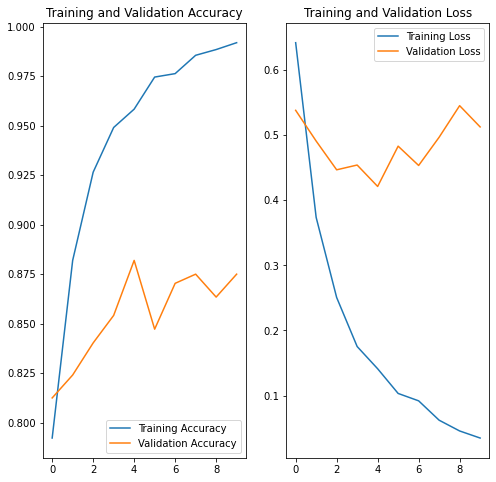

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9']


In [31]:
final={0:'新加坡猫',1:'豹猫',2:'伯曼猫',3:'孟买猫',4:'英国短毛猫',5:'埃及猫',6:'缅因猫',7:'波斯猫',8:'雪鞋猫',9:'俄罗斯蓝猫',10:'泰国暹罗猫',11:'斯芬克斯猫'}

In [32]:
listt=['https://baike.baidu.com/item/%E6%96%B0%E5%8A%A0%E5%9D%A1%E7%8C%AB/671184?fr=aladdin#2',
'https://baike.baidu.com/item/%E8%B1%B9%E7%8C%AB/4921581?fr=aladdin',
'https://baike.baidu.com/item/%E4%BC%AF%E6%9B%BC%E7%8C%AB/641852?fr=aladdin',
'https://baike.baidu.com/item/%E5%AD%9F%E4%B9%B0%E7%8C%AB/4510178?fr=aladdin',
'https://baike.baidu.com/item/%E8%8B%B1%E5%9B%BD%E7%9F%AD%E6%AF%9B%E7%8C%AB/672846?fr=aladdin',
'https://baike.baidu.com/item/%E5%9F%83%E5%8F%8A%E7%8C%AB/386503?fr=aladdin',
'https://baike.baidu.com/item/%E7%BC%85%E5%9B%A0%E7%8C%AB/647590?fr=aladdin',
'https://baike.baidu.com/item/%E6%B3%A2%E6%96%AF%E7%8C%AB/585?fr=aladdin',
'https://baike.baidu.com/item/%E9%9B%AA%E9%9E%8B%E7%8C%AB/4513092',
'https://baike.baidu.com/item/%E4%BF%84%E7%BD%97%E6%96%AF%E8%93%9D%E7%8C%AB/643065?fr=aladdin',
'https://baike.baidu.com/item/%E6%9A%B9%E7%BD%97%E7%8C%AB/556082?fr=aladdin',
'https://baike.baidu.com/item/%E5%8A%A0%E6%8B%BF%E5%A4%A7%E6%97%A0%E6%AF%9B%E7%8C%AB/643507?fromtitle=%E6%96%AF%E8%8A%AC%E5%85%8B%E6%96%AF%E7%8C%AB&fromid=8028531&fr=aladdin']

In [36]:
img = Image.open('./cats/11/zup0tJLKXZRV27AToUvQdES9xW6fsw34.jpg')
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

#print(
#    "This image most likely belongs to {} with a {:.2f} percent confidence."
#    .format(class_names[np.argmax(score)], 100 * np.max(score))
#)
#print(class_names[np.argmax(score)])
os.system('"C:/Program Files/Internet Explorer/iexplore.exe" %s'%(listt[int(class_names[np.argmax(score)])]))

1